Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

### Colab free was very slow. so using kaggle below for image datasource

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
# check if we have the dataset uploaded correctly.
import glob
for item in glob.glob("/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/*"):
   print(item) # prints full file path

/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test
/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure you resize your images to the size img_height*img_width specified above, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure you resize your images to the size img_height*img_width as specified above, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

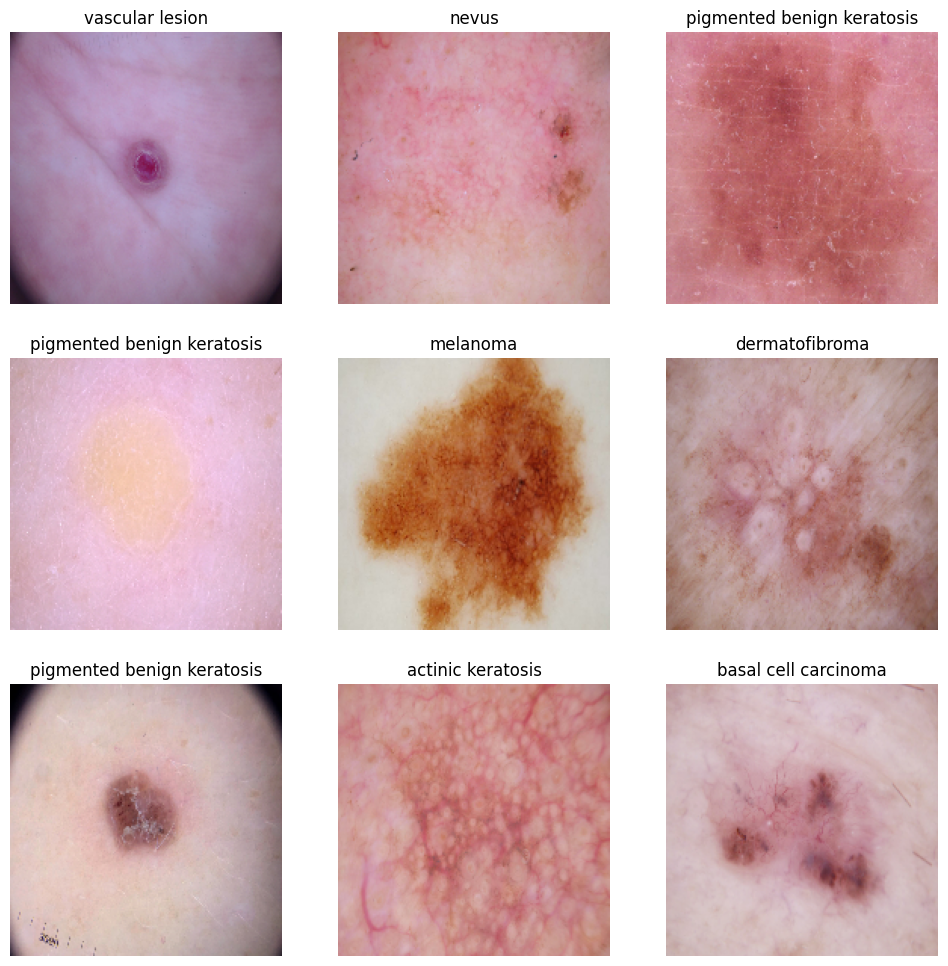

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Choose an appropirate optimiser and loss function

# Adam (Adaptive Moment Estimation) optimizer, which is a popular optimization algorithm used for training neural networks

# Loss function: SparseCategoricalCrossentropy(from_logits=True)
# This is used for multi-class classification tasks.
# Suitable when the model outputs logits (unscaled raw scores) without any activation function in the final layer.
# Labels should be integers representing the class indices (e.g., 0, 1, 2 for three classes).
# from_logits=True: Indicates that the output of the model is logits and not probabilities. This is important to ensure the loss function correctly applies the softmax internally.
# Usage scenario: Use this when you have a multi-class classification problem and your model's final layer does not include an activation function like softmax.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.2413 - loss: 2.1730 - val_accuracy: 0.3065 - val_loss: 1.8645
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3488 - loss: 1.7675 - val_accuracy: 0.4385 - val_loss: 1.6722
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4558 - loss: 1.5496 - val_accuracy: 0.5123 - val_loss: 1.4360
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5431 - loss: 1.3258 - val_accuracy: 0.5257 - val_loss: 1.4637
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5638 - loss: 1.2338 - val_accuracy: 0.5190 - val_loss: 1.3799
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5957 - loss: 1.1681 - val_accuracy: 0.5481 - val_loss: 1.3652
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6218 - loss: 1.0980 - val_accuracy: 0.5101 - val_loss: 1.4567
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6492 - loss: 0.9592 - val_accuracy: 0.4787 - 

### Visualizing training results

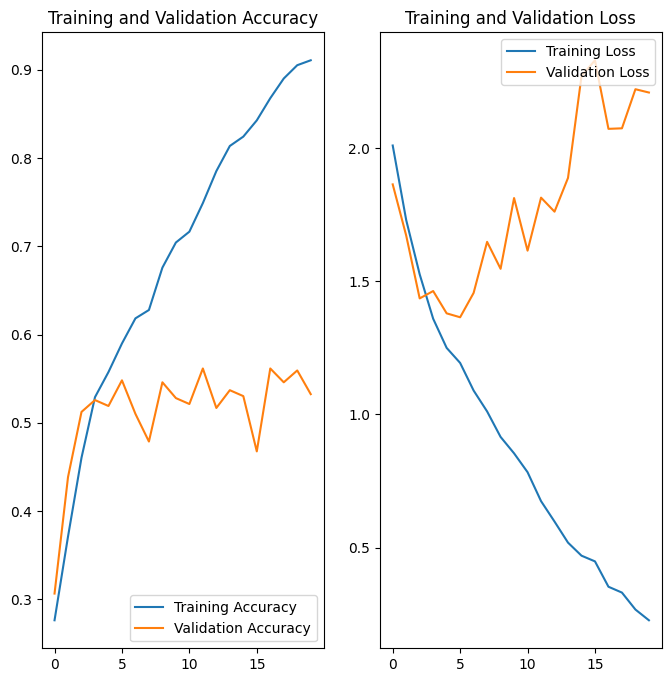

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)




56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9287 - loss: 0.2107
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - loss: 2.1797
Accuracy:  0.9274553656578064
Validation Accuracy:  0.5324384570121765
Loss:  0.20328709483146667
Validation Loss 2.209627866744995


### Write your findings here

**Observations:**

From chart one we can see that the model accuracy increases till 90%, but validation accuracy remains consistently around 55%.

Clearly we can see from the data above and chart that it is case of model overfit. This may be because of less data to train so    we need to increase training data. We will use augmentation techniques to increase the training data.

**Data augmentation** is a technique used to artificially increase the size of your training dataset by applying transformations to the existing data. In Keras/TensorFlow, the tf.keras.preprocessing and tf.image modules, along with the Keras ImageDataGenerator and tf.keras.layers for augmentation layers, provide robust tools for data augmentation.

In [22]:
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

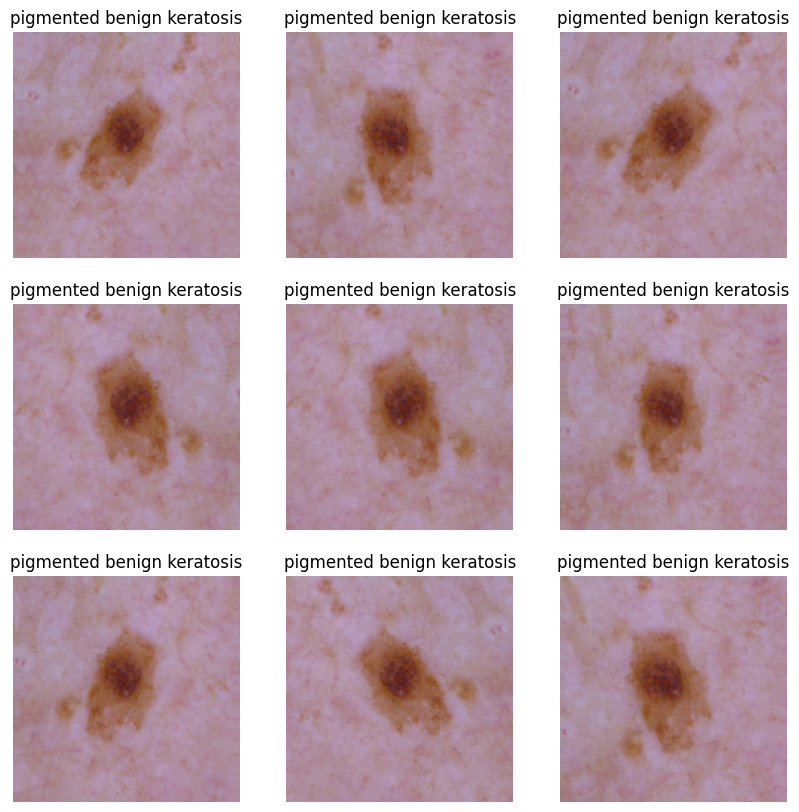

In [23]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model


In [24]:
## Since we see that previous model was overfitting we are using Dropout layer.

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])



### Compiling the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
# train your model for 20 epochs as we did the same in previous run as well.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2289 - loss: 2.4035 - val_accuracy: 0.3579 - val_loss: 1.7892
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4146 - loss: 1.6977 - val_accuracy: 0.4474 - val_loss: 1.5762
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4479 - loss: 1.5550 - val_accuracy: 0.4452 - val_loss: 1.5548
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4671 - loss: 1.4718 - val_accuracy: 0.4922 - val_loss: 1.4228
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5023 - loss: 1.4132 - val_accuracy: 0.5257 - val_loss: 1.4054
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4906 - loss: 1.4233 - val_accuracy: 0.5190 - val_loss: 1.3991
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5159 - loss: 1.3371 - val_accuracy: 0.5101 - val_loss: 1.4166
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5307 - loss: 1.3190 - val_accuracy: 0.5302 - v

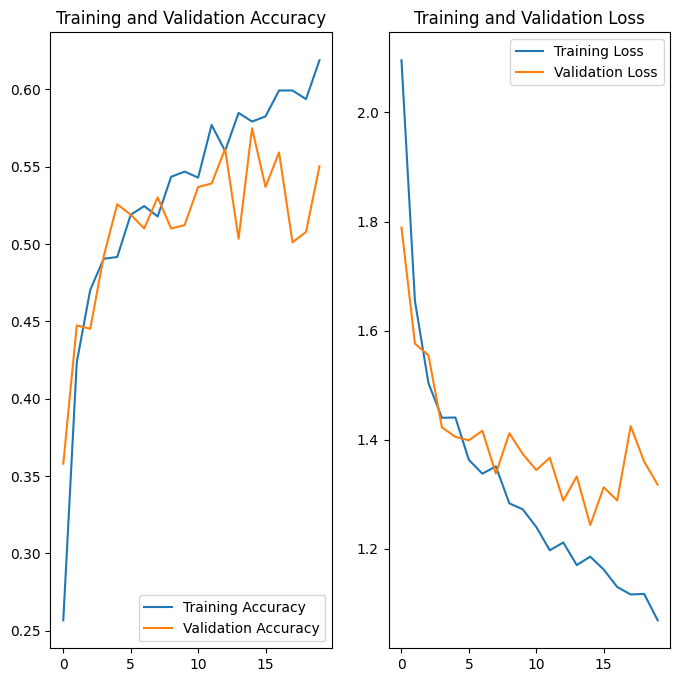

In [27]:
# Plot the chart for results.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations:**

Overfitting has been addressed by using augmented data.

The training and validation accuracy now can be see in the same range from the charts and above run.

Both the training and validation data are showing poor performance, indicating that the model is now underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(images_path_list))

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239
2239


In [29]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0028100.jpg', 'pigmented benign keratosis'), ('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0027960.jpg', 'pigmented benign keratosis'), ('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025454.jpg', 'pigmented benign keratosis'), ('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025876.jpg', 'pigmented benign keratosis'), ('/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025575.jpg', 'pigmented benign keratosis')]


In [30]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/kaggle/input/cnn-images/Skin cancer ISIC The ...,pigmented benign keratosis
1,/kaggle/input/cnn-images/Skin cancer ISIC The ...,pigmented benign keratosis
2,/kaggle/input/cnn-images/Skin cancer ISIC The ...,pigmented benign keratosis
3,/kaggle/input/cnn-images/Skin cancer ISIC The ...,pigmented benign keratosis
4,/kaggle/input/cnn-images/Skin cancer ISIC The ...,pigmented benign keratosis


In [31]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

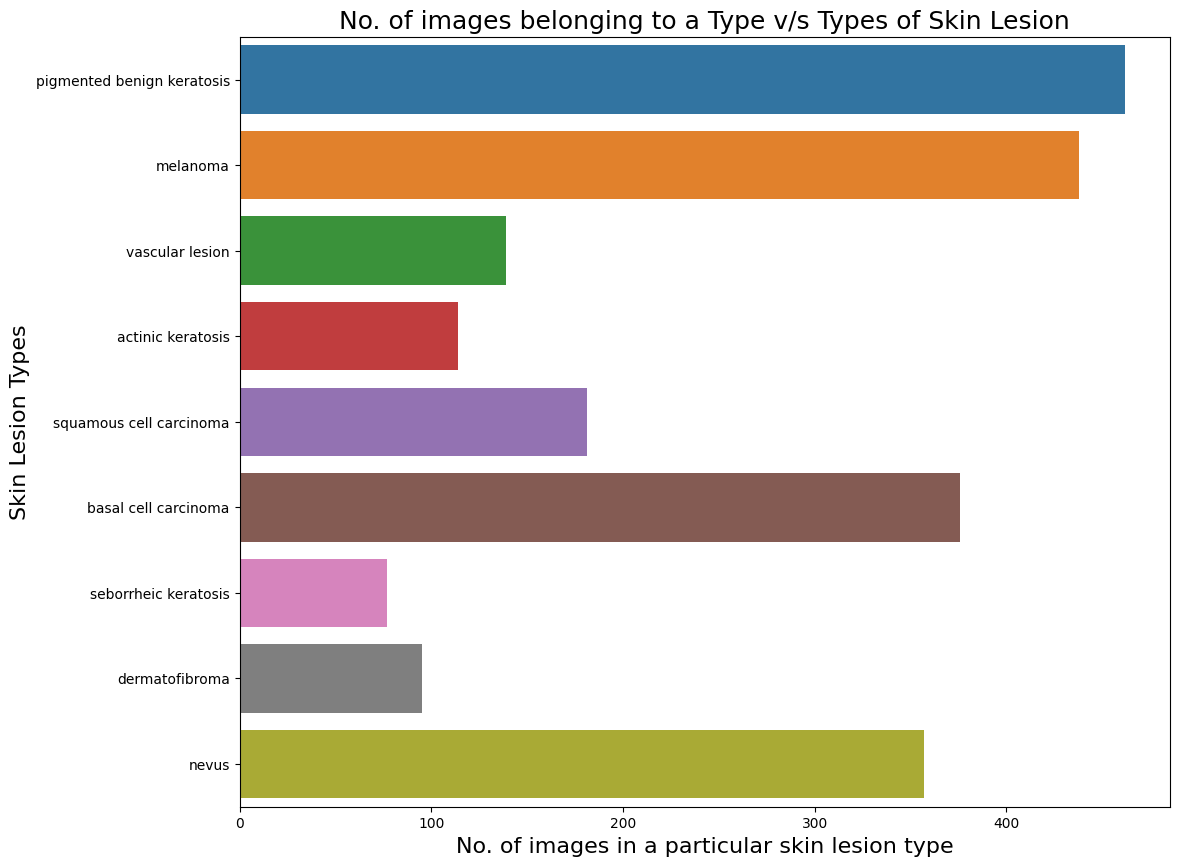

In [32]:
# using seaborn library to plot the chart

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=18)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=16)
plt.ylabel('Skin Lesion Types', fontsize=16)
plt.show()

In [33]:
# Calculate the percentage of sample population for each label.
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

**Observations:**

A clear class imbalance is evident within the training data.

The class "seborrheic keratosis" has the least number of samples which is 3.44%.

"Pigmented benign keratosis" and "melanoma" dominate the data with 20.63% and 19.56% samples, respectively.

squamous cell carcinoma, vascular lesion, actinic keratosis, dermatofibroma, and seborrheic keratosis each have less than 10% samples of the dataset.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


### In Kaggle, we dont have permission to write into the input folder so I had to create a new directory for augmented images.

In [35]:
path_to_training_dataset= '/kaggle/input/cnn-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
new_dir = '/kaggle/working/aug_output'
import Augmentor
for i in class_names:
    class_dir = os.path.join(path_to_training_dataset , i)
    output_dir = os.path.join(new_dir, i)
    p = Augmentor.Pipeline(class_dir, output_directory=output_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(700) ## We are adding 700 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/aug_output/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798189C7E860>: 100%|██████████| 700/700 [00:08<00:00, 85.51 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/aug_output/basal cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798189C947C0>: 100%|██████████| 700/700 [00:08<00:00, 81.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/aug_output/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798189C2CA60>: 100%|██████████| 700/700 [00:08<00:00, 78.57 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/aug_output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x798189C67280>: 100%|██████████| 700/700 [00:48<00:00, 14.41 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/aug_output/nevus.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798189B22CB0>: 100%|██████████| 700/700 [00:47<00:00, 14.62 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/aug_output/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7981C44DCF10>: 100%|██████████| 700/700 [00:08<00:00, 80.74 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/aug_output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7981C439E8F0>: 100%|██████████| 700/700 [00:21<00:00, 32.80 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/aug_output/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7981C4185DB0>: 100%|██████████| 700/700 [00:08<00:00, 84.79 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/aug_output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7981E1936740>: 100%|██████████| 700/700 [00:08<00:00, 83.35 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
path_to_training_datasetlib = pathlib.Path("/kaggle/working/aug_output/")
image_count_train = len(list(path_to_training_datasetlib.glob('*/*.jpg')))
print(image_count_train)

6300


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
from glob import glob
path_list = [x for x in glob(os.path.join(path_to_training_datasetlib, '*', '*.jpg'))]
path_list[:5]

['/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010993.jpg_4c1f60c8-bbee-425b-af92-9f9d297b98c0.jpg',
 '/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010863.jpg_34a44053-cf88-4b63-a779-d0e717b45a92.jpg',
 '/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010866.jpg_54b596a7-ca23-4e49-85cc-2207cf1f0b1a.jpg',
 '/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010863.jpg_0814832d-5aaa-428c-a09a-fb8601895702.jpg',
 '/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010883.jpg_0d23844b-dc64-4afe-9f54-e04fd981954f.jpg']

In [38]:
# Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(path_to_training_datasetlib, '*', '*.jpg')) ]
print(lesions_list[:5])

['seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis']


In [39]:
dataframe_dict_new = dict(zip(path_list, lesions_list))
print(list(dataframe_dict_new.items())[:5])

[('/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010993.jpg_4c1f60c8-bbee-425b-af92-9f9d297b98c0.jpg', 'seborrheic keratosis'), ('/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010863.jpg_34a44053-cf88-4b63-a779-d0e717b45a92.jpg', 'seborrheic keratosis'), ('/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010866.jpg_54b596a7-ca23-4e49-85cc-2207cf1f0b1a.jpg', 'seborrheic keratosis'), ('/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010863.jpg_0814832d-5aaa-428c-a09a-fb8601895702.jpg', 'seborrheic keratosis'), ('/kaggle/working/aug_output/seborrheic keratosis/seborrheic keratosis_original_ISIC_0010883.jpg_0d23844b-dc64-4afe-9f54-e04fd981954f.jpg', 'seborrheic keratosis')]


In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([lesions_df,df2])
print(new_df.shape)


(8539, 3)


In [41]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1162
melanoma                      1138
basal cell carcinoma          1076
nevus                         1057
squamous cell carcinoma        881
vascular lesion                839
actinic keratosis              814
dermatofibroma                 795
seborrheic keratosis           777
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [42]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    13.61
melanoma                      13.33
basal cell carcinoma          12.60
nevus                         12.38
squamous cell carcinoma       10.32
vascular lesion                9.83
actinic keratosis              9.53
dermatofibroma                 9.31
seborrheic keratosis           9.10
Name: proportion, dtype: float64

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train="/kaggle/working/aug_output/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    seed=123,subset="training",
    validation_split=0.2,
)

Found 6300 files belonging to 9 classes.
Using 5040 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    seed=123,
    subset="validation",
    validation_split=0.2)

Found 6300 files belonging to 9 classes.
Using 1260 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### **Todo:**  Train your model

In [48]:
# Train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1732 - loss: 2.2892
Epoch 1: val_accuracy improved from -inf to 0.36508, saving model to model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.1737 - loss: 2.2873 - val_accuracy: 0.3651 - val_loss: 1.6363
Epoch 2/30
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3880 - loss: 1.5815
Epoch 2: val_accuracy improved from 0.36508 to 0.47937, saving model to model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3882 - loss: 1.5811 - val_accuracy: 0.4794 - val_loss: 1.4247
Epoch 3/30
156/158 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4573 - loss: 1.4558
Epoch 3: val_accuracy did not improve from 0.47937
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4572 - loss: 1.4556 - val_accuracy: 0.4770 - val_loss: 1.3534
Epoch 4/30
156/158 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4599 - loss: 1.3957
Epoch 4: val_accuracy improved from 0.47937 to 0.50476, saving model to model.ker

#### **Todo:**  Visualize the model results

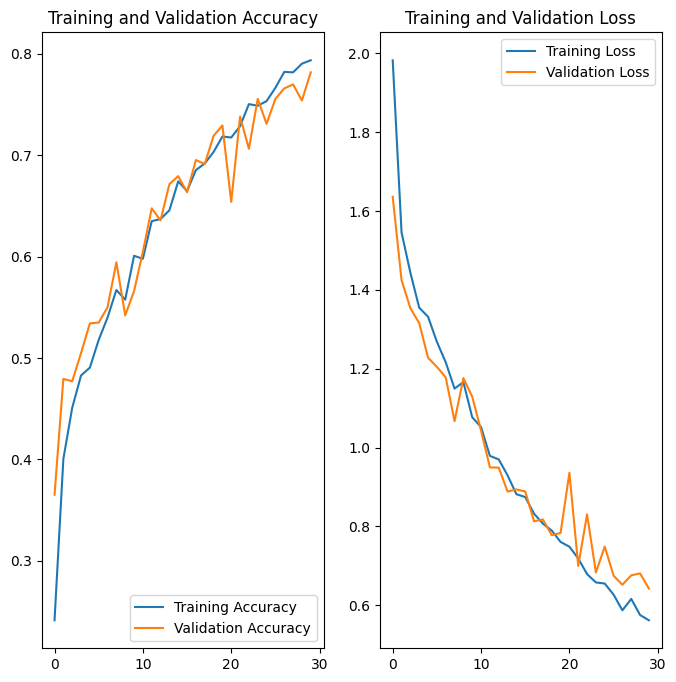

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Observations:**

The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting. We can further improve model by trying other techniques like regularization, more images for training and we can also experiment with batch sizes.

The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

Following 29 epochs, the final model attains an accuracy of 79.27% on the training set and approximately 78.17% on the validation set.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


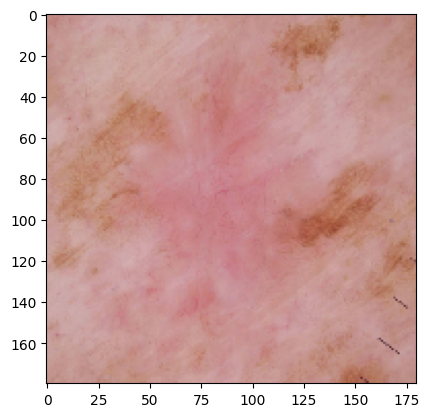

In [52]:
# Lets evaluate the model

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)